In [1]:
import numpy as np
from scipy.integrate import solve_bvp


def _differential_equation(mu, u, n, a2):
    """
    The differential equation to solve for P

    :param mu: cos(theta)
    :param u: P function and derivative
    :param n: variable according to Low & Lou (1989)
    :param a2: eigenvalue

    """
    P, dP = u
    dP_dmu = dP
    d2P_dmu2 = -(n * (n + 1) * P + a2 * (1 + n) / n * P ** (1 + 2 / n)) / (1 - mu ** 2 + 1e-8)
    return (dP_dmu, d2P_dmu2)


def get_analytic_b_field(n=1, m=1, l=0.3, psi=np.pi / 4, resolution=64, bounds=[-1, 1, -1, 1, 0, 2]):
    """
    Calculate the analytic NLFF field from Low & Lou (1989).

    :param n: variable see Low & Lou (1989), only works for n=1
    :param m: used for generating a proper initial condition.
    :param a2: eigenvalue
    :param l: depth below the photosphere
    :param psi: angle of the magnetic field relative to the dipol axis
    :param resolution: spatial resolution of the magnetic field in pixels
    :param bounds: dimensions of the volume (x_start, x_end, y_start, y_end, z_start, z_end)
    :return: magnetic field B (x, y, z, v)
    """
    sol_P, a2 = solve_P(n, m)

    resolution = [resolution] * 3 if not isinstance(resolution, list) else resolution
    coords = np.stack(np.meshgrid(np.linspace(bounds[0], bounds[1], resolution[1], dtype=np.float32),
                                  np.linspace(bounds[2], bounds[3], resolution[0], dtype=np.float32),
                                  np.linspace(bounds[4], bounds[5], resolution[2], dtype=np.float32)), -1).transpose(
        [1, 0, 2, 3])

    x, y, z = coords[..., 0], coords[..., 1], coords[..., 2]
    X = x * np.cos(psi) - (z + l) * np.sin(psi)
    Y = y
    Z = x * np.sin(psi) + (z + l) * np.cos(psi)

    # to spherical coordinates
    xy = X ** 2 + Y ** 2
    r = np.sqrt(xy + Z ** 2)
    theta = np.arctan2(np.sqrt(xy), Z)
    phi = np.arctan2(Y, X)

    mu = np.cos(theta)

    P, dP_dmu = sol_P(mu)
    A = P / r ** n
    dA_dtheta = -np.sin(theta) / (r ** n) * dP_dmu
    dA_dr = P * (-n * r ** (-n - 1))
    Q = np.sqrt(a2) * A * np.abs(A) ** (1 / n)

    Br = (r ** 2 * np.sin(theta)) ** -1 * dA_dtheta
    Btheta = - (r * np.sin(theta)) ** -1 * dA_dr
    Bphi = (r * np.sin(theta)) ** -1 * Q

    BX = Br * np.sin(theta) * np.cos(phi) + Btheta * np.cos(theta) * np.cos(phi) - Bphi * np.sin(phi)
    BY = Br * np.sin(theta) * np.sin(phi) + Btheta * np.cos(theta) * np.sin(phi) + Bphi * np.cos(phi)
    BZ = Br * np.cos(theta) - Btheta * np.sin(theta)

    Bx = BX * np.cos(psi) + BZ * np.sin(psi)
    By = BY
    Bz = - BX * np.sin(psi) + BZ * np.cos(psi)

    b_field = np.real(np.stack([Bx, By, Bz], -1))
    return b_field


def solve_P(n, m):
    """
    Solve the differential equation from Low & Lou (1989).

    :param n: variable (only n=1)
    :param v0: start condition for dP/dmu
    :param P0: boundary condition for P(-1) and P(1)
    :return: interpolated functions for P and dP/dmu
    """

    def f(x, y, p):
        a2 = p[0]
        d2P_dmu2 = -(n * (n + 1) * y[0] + a2 * (1 + n) / n * y[0] ** (1 + 2 / n)) / (1 - x ** 2 + 1e-6)
        return [y[1], d2P_dmu2]

    def f_boundary(Pa, Pb, p):
        return np.array([Pa[0] - 0, Pb[0] - 0, Pa[1] - 10])

    mu = np.linspace(-1, 1, num=256)

    if m % 2 == 0:
        init = np.cos(mu * (m + 1) * np.pi / 2)
    else:
        init = np.sin(mu * (m + 1) * np.pi / 2)

    dinit = 10 * np.ones_like(init)  #
    initial = np.stack([init, dinit])

    @np.vectorize
    def shooting(a2_init):
        eval = solve_bvp(f, f_boundary, x=mu, y=initial, p=[a2_init], verbose=0, tol=1e-6)
        if eval.success == False:
            return None
        return eval

    # use shooting to find eigenvalues
    evals = shooting(np.linspace(0, 10, 100, dtype=np.float32))
    evals = [e for e in evals if e is not None]

    eigenvalues = np.array([e.p for e in evals])
    eigenvalues = sorted(set(np.round(eigenvalues, 4).reshape((-1,))))

    # get final solution
    eval = shooting([eigenvalues[-1]])[0]

    return eval.sol, eval.p[0]

In [2]:
b = get_analytic_b_field(n=1, m=1, l=0.3, psi=np.pi/2, resolution=64, bounds=[-1, 1, -1, 1, 0, 2])
np.save("b.npy", b)

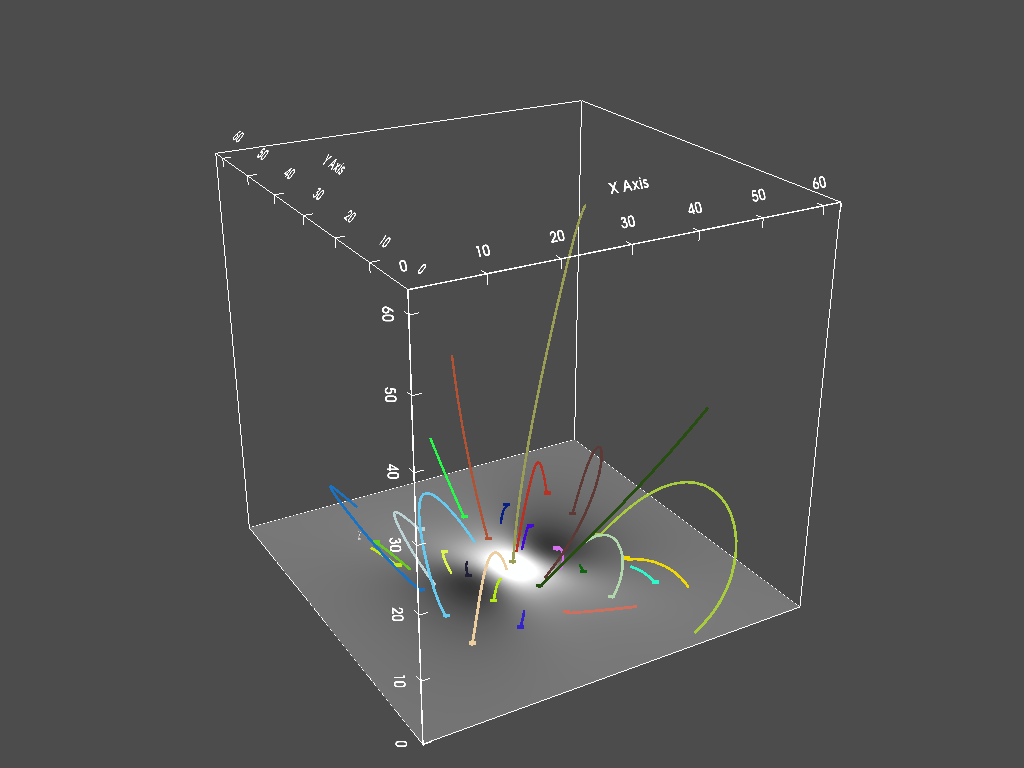

In [4]:
b = np.load("b.npy")

from pinf.plot import pv_plot
p = pv_plot(b, vtk_path='b.vtk', points=((16, 49, 8), (16, 49, 8)))
p.camera_position = 'xz'
p.camera.azimuth = -30
p.camera.elevation = 25
p.show(jupyter_backend='static')